In [1]:
# https://forums.fast.ai/t/unet-binary-segmentation/29833/36
# https://walkwithfastai.com/Binary_Segmentation
# https://www.tensorflow.org/tutorials/images/segmentation

from fastai.vision.all import *
# %% [markdown]
# images
path = Path(".").absolute().parent / "data/train"
fnames = get_image_files(path/"images")
print('example file name:', fnames[0])
print('of', len(fnames), 'training examples')

example file name: d:\Dev\hedgehog_finder\data\train\images\1\1.png
of 301 training examples


## Define DataLoaders

In [2]:
from hedgiefinder.dataloading import get_msk

codes = ['Background', 'Hog', 'Outline']

hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_msk,
                   batch_tfms=aug_transforms(do_flip=False, max_rotate=2),
                   item_tfms=Resize(224, method='squish'))

dls = hogvid.dataloaders(path / "images", path=path, bs=8)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


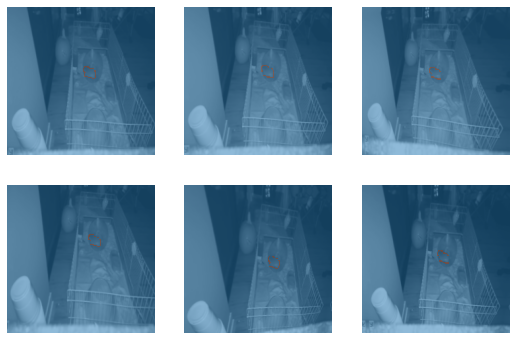

In [3]:
dls.show_batch(max_n=6, unique=True)

In [4]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 224, 224]))

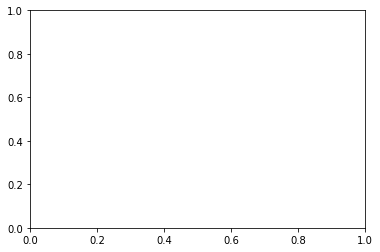

epoch,train_loss,valid_loss,time
0,0.032330,0.047251,00:28
1,0.026716,0.043557,00:27
2,0.021899,0.050076,00:28
3,0.018224,0.058345,00:27
4,0.015546,0.021346,00:27
5,0.014038,0.030258,00:27
6,0.013470,0.031256,00:28
7,0.011592,0.047167,00:28
8,0.010111,0.035574,00:28
9,0.008954,0.015826,00:28


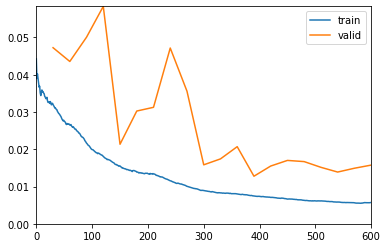

In [5]:
learn = unet_learner(dls, resnet34, cbs=ShowGraphCallback())
learn.fine_tune(20)

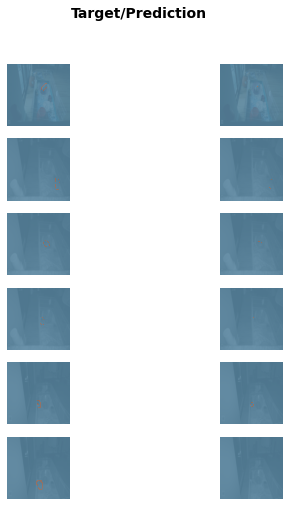

In [6]:
learn.show_results(max_n=6, figsize=(7,8))

In [7]:
from PIL import Image

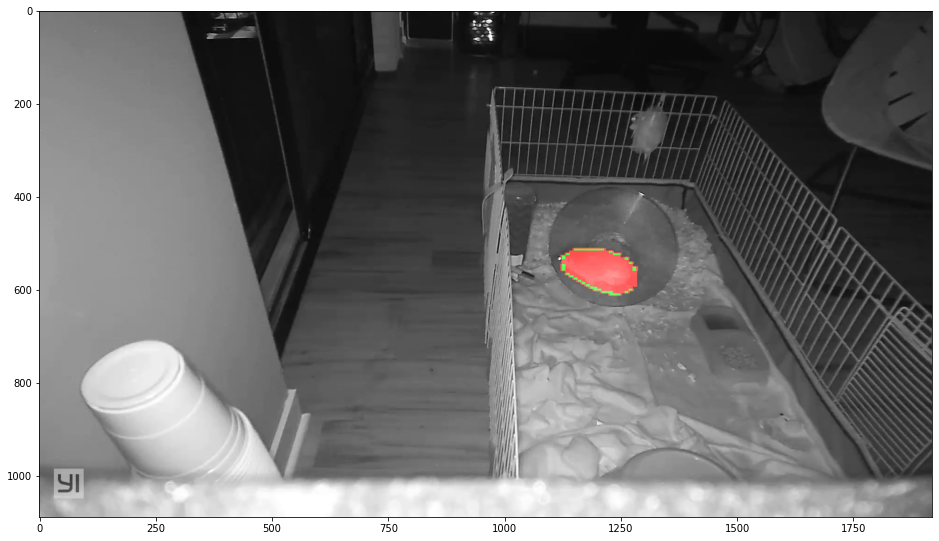

In [8]:
import matplotlib.pyplot as plt
out = learn.predict(fnames[0])
# %%
def show_res(fn):
  im = np.array(PILImage.create(fn))
  out = learn.predict(fn)[1]
  mask = np.array(Image.fromarray(out.numpy().astype(np.uint8)).resize((1920,1088)))
  im[mask==1, 0] = 255
  im[mask==2, 1] = 255
  f, axs = plt.subplots(1,1, figsize=(16,16))
  axs.imshow(im)

show_res(fnames[25])

In [37]:
model_path = path.parent.parent / 'hedgiefinder' / 'models'

In [38]:
from datetime import datetime
model_name = model_path / datetime.now().strftime("%Y%m%d_%H%M.pkl")

In [39]:
model_dir = model_name.parent
model_dir.mkdir(exist_ok=True)

In [40]:
learn.export(model_name)

In [41]:
print(model_name)

d:\Dev\hedgehog_finder\hedgiefinder\models\20210304_0025.pkl
